# 분류

## 기본 분류기와 SVM 공통 코드

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import pandas as pd

import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import seaborn as sns

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "svm"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 피셔의 선형 판별

### borrower_score 와 payment_inc_ratio에 따른 outcome 판별 분석

In [2]:
#데이터 읽어오기
loan3000 = pd.read_csv('./data/loan3000.csv')
loan3000.outcome = loan3000.outcome.astype('category')

predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

#데이터 읽어오기
X = loan3000[predictors]
y = loan3000[outcome]

print(X.head())
print()
print(y.head())

   borrower_score  payment_inc_ratio
0            0.40            5.11135
1            0.40            5.43165
2            0.70            9.23003
3            0.40            2.33482
4            0.45           12.10320

0    paid off
1     default
2    paid off
3    paid off
4     default
Name: outcome, dtype: category
Categories (2, object): ['default', 'paid off']


In [3]:
#LDA 훈련
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
loan_lda = LinearDiscriminantAnalysis()
loan_lda.fit(X, y)
#최적의 borrower_score 와 payment_inc_ratio 값 구하기
print(pd.DataFrame(loan_lda.scalings_, index=X.columns))

                          0
borrower_score     7.175839
payment_inc_ratio -0.099676


In [4]:
#예측에 대한 확률 출력
pred = pd.DataFrame(loan_lda.predict_proba(loan3000[predictors]),
                    columns=loan_lda.classes_)
print(pred.head())

    default  paid off
0  0.553544  0.446456
1  0.558953  0.441047
2  0.272696  0.727304
3  0.506254  0.493746
4  0.609952  0.390048


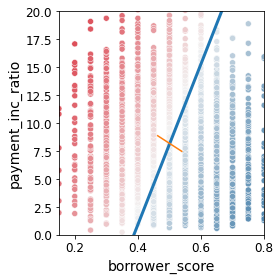

In [5]:
#그래프 그리기 - 대각선의 왼쪽은 default 반대쪽은 paid off
center = np.mean(loan_lda.means_, axis=0)
slope = - loan_lda.scalings_[0] / loan_lda.scalings_[1]
intercept = center[1] - center[0] * slope

# payment_inc_ratio for borrower_score of 0 and 20
x_0 = (0 - intercept) / slope
x_20 = (20 - intercept) / slope

lda_df = pd.concat([loan3000, pred['default']], axis=1)
lda_df.head()

fig, ax = plt.subplots(figsize=(4, 4))
g = sns.scatterplot(x='borrower_score', y='payment_inc_ratio',
                    hue='default', data=lda_df, 
                    palette=sns.diverging_palette(240, 10, n=9, as_cmap=True),
                    ax=ax, legend=False)

ax.set_ylim(0, 20)
ax.set_xlim(0.15, 0.8)
ax.plot((x_0, x_20), (0, 20), linewidth=3)
ax.plot(*loan_lda.means_.transpose())

plt.tight_layout()
plt.show()

## 더미(랜덤)분류기

In [6]:
# 라이브러리를 임포트합니다.
from sklearn.datasets import load_iris
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split

# 데이터를 로드합니다.
iris = load_iris()

# 타깃 벡터와 특성 행렬을 만듭니다.
features, target = iris.data, iris.target

# 훈련 세트와 테스트 세트로 나눕니다.
features_train, features_test, target_train, target_test = train_test_split(
features, target, random_state=0)

# 더미 분류 모델을 만듭니다.
dummy = DummyClassifier(strategy='uniform', random_state=1)

# 모델을 훈련합니다.
dummy.fit(features_train, target_train)

print(dummy.predict(features_test))
# 정확도 점수를 계산합니다.
print(dummy.score(features_test, target_test))

[1 0 0 1 1 0 0 1 0 1 0 2 1 2 0 2 1 2 0 0 2 0 1 2 2 0 1 1 2 0 2 1 1 1 1 2 1
 1]
0.42105263157894735


In [7]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(features_train, target_train)
# 훈련 세트 타깃에서 가장 많은 값으로 예측합니다. 
print(dummy.predict(features_test))
print(dummy.score(features_test, target_test))

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2]
0.23684210526315788


In [8]:
#MNIST 데이터의 5와 그렇지 않은 이미지의 DummyClassifier
from sklearn.datasets import fetch_openml
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist["data"], mnist["target"]
y = y.astype(np.uint8)
    
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

dmy_clf = DummyClassifier(strategy='stratified')

# 모델을 훈련합니다.
dummy.fit(X_train, y_train_5)

print(dummy.predict(X_test))
# 정확도 점수를 계산합니다.
print(dummy.score(X_test, y_test_5))

[False False False ... False False False]
0.9108


## KNN 분류기

In [9]:
from sklearn.neighbors import KNeighborsClassifier

#데이터 불러오기
loan200 = pd.read_csv('data/loan200.csv')

predictors = ['payment_inc_ratio', 'dti']
outcome = 'outcome'


#테스트 데이터와 예측 변수 및 타겟 벡터 분리
newloan = loan200.loc[0:0, predictors]
X = loan200.loc[1:, predictors]
y = loan200.loc[1:, outcome]

#분류기 생성 - k 의 개수는 20
knn = KNeighborsClassifier(n_neighbors=20)
#훈련 
knn.fit(X, y)
#예측
knn.predict(newloan)

array(['paid off'], dtype=object)

In [10]:
#확률 출력
print(knn.predict_proba(newloan))

[[0.45 0.55]]


In [11]:
#가까운 이웃 구하기
nbrs = knn.kneighbors(newloan)
#테스트 데이터와 가장 먼 거리 찾기
maxDistance = np.max(nbrs[0][0])
print(maxDistance)

3.541426301647403


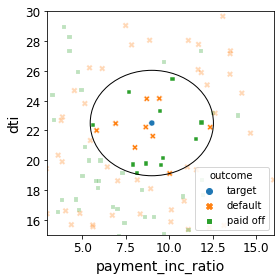

In [12]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.scatterplot(x='payment_inc_ratio', y='dti', style='outcome', 
                hue='outcome', data=loan200, alpha=0.3, ax=ax)
sns.scatterplot(x='payment_inc_ratio', y='dti', style='outcome', 
                hue='outcome', 
                data=pd.concat([loan200.loc[0:0, :], loan200.loc[nbrs[1][0] + 1,:]]), 
                ax=ax, legend=False)
ellipse = Ellipse(xy=newloan.values[0], 
                  width=2 * maxDistance, height=2 * maxDistance,
                  edgecolor='black', fc='None', lw=1)
ax.add_patch(ellipse)
ax.set_xlim(3, 16)
ax.set_ylim(15, 30)

plt.tight_layout()
plt.show()

### 정규화

In [13]:
loan_data = pd.read_csv('data/loan_data.csv.gz')
loan_data = loan_data.drop(columns=['Unnamed: 0', 'status'])
loan_data['outcome'] = pd.Categorical(loan_data['outcome'], 
                                      categories=['paid off', 'default'], 
                                      ordered=True)


predictors = ['payment_inc_ratio', 'dti', 'revol_bal', 'revol_util']
outcome = 'outcome'

newloan = loan_data.loc[0:0, predictors]
print(newloan)


   payment_inc_ratio  dti  revol_bal  revol_util
0             2.3932  1.0       1687         9.4


In [14]:
#정규화를 하지 않은 경우 가까운 5개의 이웃 구하기
X = loan_data.loc[1:, predictors]
y = loan_data.loc[1:, outcome]

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X, y)

nbrs = knn.kneighbors(newloan)
print(X.iloc[nbrs[1][0], :])

       payment_inc_ratio   dti  revol_bal  revol_util
35536            1.47212  1.46       1686        10.0
33651            3.38178  6.37       1688         8.4
25863            2.36303  1.39       1691         3.5
42953            1.28160  7.14       1684         3.9
43599            4.12244  8.98       1684         7.2


In [15]:
#정규화를 한 경우 5개의 이웃 구하기
from sklearn import preprocessing

newloan = loan_data.loc[0:0, predictors]
X = loan_data.loc[1:, predictors]
y = loan_data.loc[1:, outcome]

scaler = preprocessing.StandardScaler()
scaler.fit(X * 1.0)

X_std = scaler.transform(X * 1.0)
newloan_std = scaler.transform(newloan * 1.0)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_std, y)

nbrs = knn.kneighbors(newloan_std)
print(X.iloc[nbrs[1][0], :])

       payment_inc_ratio   dti  revol_bal  revol_util
2080             2.61091  1.03       1218         9.7
1438             2.34343  0.51        278         9.9
30215            2.71200  1.34       1075         8.5
28542            2.39760  0.74       2917         7.4
44737            2.34309  1.37        488         7.2


### 새로운 피쳐 추가

count    45342.000000
mean         0.501104
std          0.128734
min          0.000000
25%          0.400000
50%          0.500000
75%          0.600000
max          0.950000
Name: borrower_score, dtype: float64


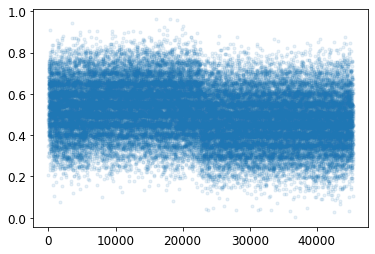

In [16]:
import random
#데이터 읽어오기
loan_data = pd.read_csv('data/loan_data.csv.gz')
#첫번째 행 제거
loan_data = loan_data.drop(columns=['Unnamed: 0', 'status'])
#데이터를 범주형으로 변환
loan_data['outcome'] = pd.Categorical(loan_data['outcome'], 
                                      categories=['paid off', 'default'], 
                                      ordered=True)

predictors = ['dti', 'revol_bal', 'revol_util', 'open_acc', 
              'delinq_2yrs_zero', 'pub_rec_zero']
outcome = 'outcome'

#훈련 데이터 와 타겟 벡터 생성
X = loan_data[predictors]
y = loan_data[outcome]

#훈련
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X, y)

#데이터 시각화
plt.scatter(range(len(X)), [bs + random.gauss(0, 0.015) for bs in knn.predict_proba(X)[:,0]], 
            alpha=0.1, marker='.')

#확률을 구해서 추가
loan_data['borrower_score'] = knn.predict_proba(X)[:, 0]
#데이터 출력
print(loan_data['borrower_score'].describe())

## Titanic 데이터에 KNN 적용

In [17]:
# load_dataset 함수를 사용하여 데이터프레임으로 변환
df = sns.load_dataset('titanic')
#  IPython 디스플레이 설정 - 출력할 열의 개수 한도 늘리기
pd.set_option('display.max_columns', 15)

# NaN값이 많은 deck 열을 삭제, embarked와 내용이 겹치는 embark_town 열을 삭제
rdf = df.drop(['deck', 'embark_town'], axis=1)  

# age 열에 나이 데이터가 없는 모든 행을 삭제 - age 열(891개 중 177개의 NaN 값)
rdf = rdf.dropna(subset=['age'], how='any', axis=0)  

# embarked 열의 NaN값을 승선도시 중에서 가장 많이 출현한 값으로 치환하기
most_freq = rdf['embarked'].value_counts(dropna=True).idxmax()   
rdf['embarked'].fillna(most_freq, inplace=True)

# 분석에 활용할 열(속성)을 선택 
ndf = rdf[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'embarked']]

# 원핫인코딩 - 범주형 데이터를 모형이 인식할 수 있도록 숫자형으로 변환
onehot_sex = pd.get_dummies(ndf['sex'])
ndf = pd.concat([ndf, onehot_sex], axis=1)

onehot_embarked = pd.get_dummies(ndf['embarked'], prefix='town')
ndf = pd.concat([ndf, onehot_embarked], axis=1)

ndf.drop(['sex', 'embarked'], axis=1, inplace=True)

# 속성(변수) 선택
X=ndf[['pclass', 'age', 'sibsp', 'parch', 'female', 'male', 
       'town_C', 'town_Q', 'town_S']]  #독립 변수 X
y=ndf['survived']                      #종속 변수 Y

# 설명 변수 데이터를 정규화(normalization)
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)

# train data 와 test data로 구분(7:3 비율)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10) 
# sklearn 라이브러리에서 KNN 분류 모형 가져오기
from sklearn.neighbors import KNeighborsClassifier

# 모형 객체 생성 (k=5로 설정, metric을 설정하지 않으면 minkowski 거리로 p값이 2이면 유클리드 거리 1이면 맨하턴 거리 기본은 2
knn = KNeighborsClassifier(n_neighbors=5)

# train data를 가지고 모형 학습
knn.fit(X_train, y_train)   

# test data를 가지고 y_hat을 예측 (분류) 
y_hat = knn.predict(X_test)

print(y_hat[0:10])
print(y_test.values[0:10])

# 모형 성능 평가 - Confusion Matrix 계산
from sklearn import metrics 
knn_matrix = metrics.confusion_matrix(y_test, y_hat)  
print(knn_matrix)

# 모형 성능 평가 - 평가지표 계산
knn_report = metrics.classification_report(y_test, y_hat)            
print(knn_report)

[0 0 1 0 0 1 1 1 0 0]
[0 0 1 0 0 1 1 1 0 0]
[[109  16]
 [ 25  65]]
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       125
           1       0.80      0.72      0.76        90

    accuracy                           0.81       215
   macro avg       0.81      0.80      0.80       215
weighted avg       0.81      0.81      0.81       215



## MNIST 데이터에 KNN 적용

In [18]:
from sklearn.metrics import accuracy_score
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

X, y = mnist["data"], mnist["target"]
y = y.astype(np.uint8)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
some_digit = X[0]

knn_clf = KNeighborsClassifier(weights='distance', n_neighbors=4)
knn_clf.fit(X_train, y_train)
y_knn_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_knn_pred)

0.9714

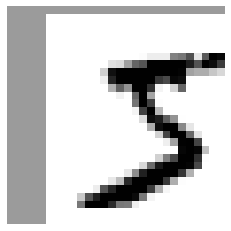

In [19]:
from scipy.ndimage.interpolation import shift
#이미지를 출력하기 위한 함수
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")
#이미지를 옮겨주는 함수    
def shift_digit(digit_array, dx, dy, new=0):
    return shift(digit_array.reshape(28, 28), [dy, dx], cval=new).reshape(784)

plot_digit(shift_digit(some_digit, 5, 1, new=100))

In [20]:
X_train_expanded = [X_train]
y_train_expanded = [y_train]
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    shifted_images = np.apply_along_axis(shift_digit, axis=1, arr=X_train, dx=dx, dy=dy)
    X_train_expanded.append(shifted_images)
    y_train_expanded.append(y_train)

X_train_expanded = np.concatenate(X_train_expanded)
y_train_expanded = np.concatenate(y_train_expanded)
X_train_expanded.shape, y_train_expanded.shape

((300000, 784), (300000,))

In [ ]:
knn_clf.fit(X_train_expanded, y_train_expanded)
y_knn_expanded_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_knn_expanded_pred)

In [ ]:
ambiguous_digit = X_test[2589]
knn_clf.predict_proba([ambiguous_digit])

In [ ]:
plot_digit(ambiguous_digit)

## 연습문제 - KNN 알고리즘 과 Grid 탐색을 이용해서 97% 정확도 찾기

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3)
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_score_

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

## Naive Bayse 분류

### Naive Bayes 분류

In [13]:
from sklearn.naive_bayes import MultinomialNB

loan_data = pd.read_csv('./data/loan_data.csv.gz')

#범주형으로 변환
loan_data.outcome = loan_data.outcome.astype('category')
loan_data.outcome.cat.reorder_categories(['paid off', 'default'])
loan_data.purpose_ = loan_data.purpose_.astype('category')
loan_data.home_ = loan_data.home_.astype('category')
loan_data.emp_len_ = loan_data.emp_len_.astype('category')

predictors = ['purpose_', 'home_', 'emp_len_']
outcome = 'outcome'

#더미의 가변수 만들기
X = pd.get_dummies(loan_data[predictors], prefix='', prefix_sep='')
y = loan_data[outcome]

#분류기 생성
#MultinomialNB는 클래스별로 특성의 평균을 계산
#MultinomialNB는 모델의 복잡도를 조절하는 alpha 매개변수 하나를 가지고 있습니다. 
#alpha가 주어지면 알고리즘이 모든 특성에 양의 값을 가진 가상의 데이터 포인트를 alpha 개수만큼 추가합니다. 
#통계 데이터를 완만하게 만들어줍니다. 
#alpha가 크면 더 완만해지고 모델의 복잡도는 낮아집니다.
#alpha에 따른 알고리즘 성능 변동은 비교적 크지 않아서, alpha 값이 성능 향상에 크게 기여하지 않습니다. 
#이 값을 조정하면 어느 정도는 정확도를 높일 수 있습니다.
#fit_prior은 사전 확률을 학습할지 여부 false이면 균일 한 확률

naive_model = MultinomialNB(alpha=0.01, fit_prior=True)
#naive_model = MultinomialNB(alpha=0, fit_prior=False)
naive_model.fit(X, y)

#146번 데이터 예측
new_loan = X.loc[146:146, :]
print('predicted class: ', naive_model.predict(new_loan)[0])

#확률 출력
probabilities = pd.DataFrame(naive_model.predict_proba(new_loan),
                             columns=naive_model.classes_)
print('predicted probabilities',)
print(probabilities)

predicted class:  default
predicted probabilities
    default  paid off
0  0.653696  0.346304


### 타이타닉 데이터에 대한 Naive Bayse 분류

In [16]:
# load_dataset 함수를 사용하여 titanic 데이터 가져오기
df = sns.load_dataset('titanic')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


In [17]:
#  IPython 디스플레이 설정 - 출력할 열의 개수 한도 늘리기
pd.set_option('display.max_columns', 15)

# NaN값이 많은 deck 열을 삭제, embarked와 내용이 겹치는 embark_town 열을 삭제
rdf = df.drop(['deck', 'embark_town'], axis=1)  

# age 열에 나이 데이터가 없는 모든 행을 삭제 - age 열(891개 중 177개의 NaN 값)
rdf = rdf.dropna(subset=['age'], how='any', axis=0)  

# embarked 열의 NaN값을 승선도시 중에서 가장 많이 출현한 값으로 치환하기
most_freq = rdf['embarked'].value_counts(dropna=True).idxmax()   
rdf['embarked'].fillna(most_freq, inplace=True)

# 분석에 활용할 열(속성)을 선택 
ndf = rdf[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'embarked']]

# 원핫인코딩 - 범주형 데이터를 모형이 인식할 수 있도록 숫자형으로 변환
onehot_sex = pd.get_dummies(ndf['sex'])
ndf = pd.concat([ndf, onehot_sex], axis=1)

onehot_embarked = pd.get_dummies(ndf['embarked'], prefix='town')
ndf = pd.concat([ndf, onehot_embarked], axis=1)

ndf.drop(['sex', 'embarked'], axis=1, inplace=True)

# 속성(변수) 선택
X=ndf[['pclass', 'age', 'sibsp', 'parch', 'female', 'male', 
       'town_C', 'town_Q', 'town_S']]  #독립 변수 X
y=ndf['survived']                      #종속 변수 Y

# 설명 변수 데이터를 정규화(normalization)
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)

# train data 와 test data로 구분(7:3 비율)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10) 

In [18]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# test data를 가지고 y_hat을 예측 (분류) 
y_hat = gnb.predict(X_test)

print(y_hat[0:10])
print(y_test.values[0:10])

# 모형 성능 평가 - Confusion Matrix 계산
from sklearn import metrics 
gnb_matrix = metrics.confusion_matrix(y_test, y_hat)  
print(gnb_matrix)

# 모형 성능 평가 - 평가지표 계산
gnb_report = metrics.classification_report(y_test, y_hat)            
print(gnb_report)

[0 0 1 0 1 0 1 1 1 0]
[0 0 1 0 0 1 1 1 0 0]
[[95 30]
 [22 68]]
              precision    recall  f1-score   support

           0       0.81      0.76      0.79       125
           1       0.69      0.76      0.72        90

    accuracy                           0.76       215
   macro avg       0.75      0.76      0.75       215
weighted avg       0.76      0.76      0.76       215



# Logistic Regression

## 붓꽃의 종류 분류

### 데이터 가져오기

In [2]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename']

In [3]:
X = iris["data"][:, 3:]  # 꽃잎 너비
y = (iris["target"] == 2).astype(np.int)  # Iris virginica이면 1 아니면 0

### 모델 훈련

In [4]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver="lbfgs", random_state=42)
log_reg.fit(X, y)

LogisticRegression(random_state=42)

### 꽃잎의 너미가 0 부터 3인 데이터를 1000개 생성해서 예측하기

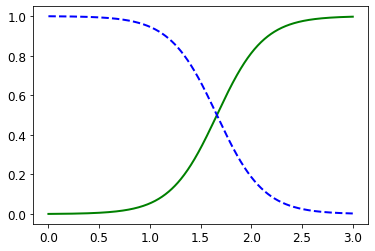

In [5]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)

plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")

/Users/adam/opt/anaconda3/lib/python3.8/site-packages/matplotlib/patches.py:1338: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  verts = np.dot(coords, M) + (x + dx, y + dy)


그림 저장: logistic_regression_plot


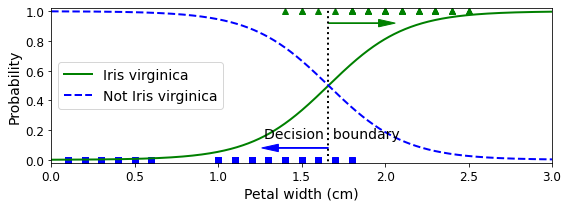

In [6]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])
save_fig("logistic_regression_plot")
plt.show()

### 결정 경계

In [7]:
decision_boundary

array([1.66066066])

### 예측

In [8]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

## petal.length 와 petal.width를 이용한 분류

그림 저장: logistic_regression_contour_plot


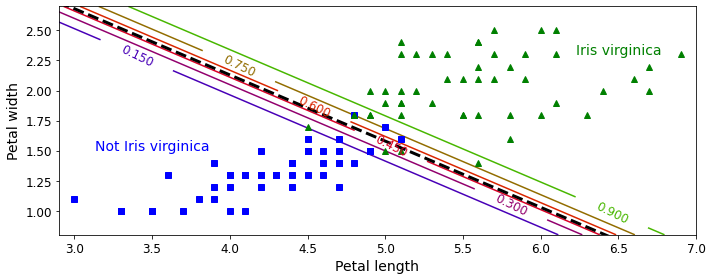

In [9]:
from sklearn.linear_model import LogisticRegression

X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.int)

log_reg = LogisticRegression(solver="lbfgs", C=10**10, random_state=42)
log_reg.fit(X, y)

x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)


left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])
save_fig("logistic_regression_contour_plot")
plt.show()

## 다중 클래스 분류

그림 저장: softmax_regression_contour_plot


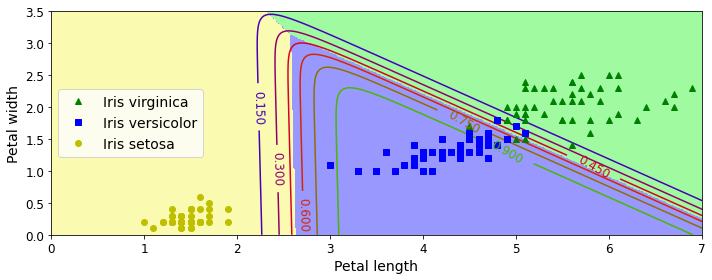

In [10]:
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = iris["target"]

#분류기 훈련
softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10, random_state=42)
softmax_reg.fit(X, y)

x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
save_fig("softmax_regression_contour_plot")
plt.show()

### 예측

In [11]:
softmax_reg.predict([[5, 2]])

array([2])

### 확률 확인

In [12]:
softmax_reg.predict_proba([[5, 2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])

## 로지스틱 회귀를 이용한 타이타닉 생존 분류

### 데이터 가져오기

In [13]:
# load_dataset 함수를 사용하여 데이터프레임으로 변환
df = sns.load_dataset('titanic')

#  IPython 디스플레이 설정 - 출력할 열의 개수 한도 늘리기
#pd.set_option('display.max_columns', 15)
print(df.head())   

   survived  pclass     sex   age  sibsp  parch     fare embarked  class  \
0         0       3    male  22.0      1      0   7.2500        S  Third   
1         1       1  female  38.0      1      0  71.2833        C  First   
2         1       3  female  26.0      0      0   7.9250        S  Third   
3         1       1  female  35.0      1      0  53.1000        S  First   
4         0       3    male  35.0      0      0   8.0500        S  Third   

     who  adult_male deck  embark_town alive  alone  
0    man        True  NaN  Southampton    no  False  
1  woman       False    C    Cherbourg   yes  False  
2  woman       False  NaN  Southampton   yes   True  
3  woman       False    C  Southampton   yes  False  
4    man        True  NaN  Southampton    no   True  


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


### 데이터 전처리

In [15]:
# NaN값이 많은 deck 열을 삭제, embarked와 내용이 겹치는 embark_town 열을 삭제
rdf = df.drop(['deck', 'embark_town'], axis=1)  
print(rdf.columns.values)
print('\n')
# age 열에 나이 데이터가 없는 모든 행을 삭제 - age 열(891개 중 177개의 NaN 값)
rdf = rdf.dropna(subset=['age'], how='any', axis=0)  
print(len(rdf))
print('\n')
# embarked 열의 NaN값을 승선도시 중에서 가장 많이 출현한 값으로 치환하기
most_freq = rdf['embarked'].value_counts(dropna=True).idxmax()   
print(most_freq)
print('\n')
print(rdf.describe(include='all'))
print('\n')
rdf['embarked'].fillna(most_freq, inplace=True)

['survived' 'pclass' 'sex' 'age' 'sibsp' 'parch' 'fare' 'embarked' 'class'
 'who' 'adult_male' 'alive' 'alone']


714


S


          survived      pclass   sex         age       sibsp       parch  \
count   714.000000  714.000000   714  714.000000  714.000000  714.000000   
unique         NaN         NaN     2         NaN         NaN         NaN   
top            NaN         NaN  male         NaN         NaN         NaN   
freq           NaN         NaN   453         NaN         NaN         NaN   
mean      0.406162    2.236695   NaN   29.699118    0.512605    0.431373   
std       0.491460    0.838250   NaN   14.526497    0.929783    0.853289   
min       0.000000    1.000000   NaN    0.420000    0.000000    0.000000   
25%       0.000000    1.000000   NaN   20.125000    0.000000    0.000000   
50%       0.000000    2.000000   NaN   28.000000    0.000000    0.000000   
75%       1.000000    3.000000   NaN   38.000000    1.000000    1.000000   
max       1.000000    3.000000   NaN   8

In [16]:
# 분석에 활용할 열(속성)을 선택 
ndf = rdf[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'embarked']]
print(ndf.head())   
print('\n')

# 원핫인코딩 - 범주형 데이터를 모형이 인식할 수 있도록 숫자형으로 변환
onehot_sex = pd.get_dummies(ndf['sex'])
ndf = pd.concat([ndf, onehot_sex], axis=1)

onehot_embarked = pd.get_dummies(ndf['embarked'], prefix='town')
ndf = pd.concat([ndf, onehot_embarked], axis=1)

ndf.drop(['sex', 'embarked'], axis=1, inplace=True)
print(ndf.head())   
print('\n')

   survived  pclass     sex   age  sibsp  parch embarked
0         0       3    male  22.0      1      0        S
1         1       1  female  38.0      1      0        C
2         1       3  female  26.0      0      0        S
3         1       1  female  35.0      1      0        S
4         0       3    male  35.0      0      0        S


   survived  pclass   age  sibsp  parch  female  male  town_C  town_Q  town_S
0         0       3  22.0      1      0       0     1       0       0       1
1         1       1  38.0      1      0       1     0       1       0       0
2         1       3  26.0      0      0       1     0       0       0       1
3         1       1  35.0      1      0       1     0       0       0       1
4         0       3  35.0      0      0       0     1       0       0       1




### 훈련 데이터 와 테스트 데이터 분할

In [17]:
# 속성(변수) 선택
X=ndf[['pclass', 'age', 'sibsp', 'parch', 'female', 'male', 'town_C', 'town_Q', 'town_S']]  #독립 변수 X
y=ndf['survived']                      #종속 변수 Y

# 설명 변수 데이터를 정규화(normalization)
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)

# train data 와 test data로 구분(7:3 비율)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10) 

print('train data 개수: ', X_train.shape)
print('test data 개수: ', X_test.shape)

train data 개수:  (499, 9)
test data 개수:  (215, 9)


In [18]:
from sklearn.linear_model import LogisticRegression

#Logistic Regression 분석 객체를 생성
lr = LogisticRegression(C=1000.0, random_state=1)
#데이터 훈련
lr.fit(X_train, y_train)

print("테스트 모델의 분류 결과")
print(lr.predict_proba(X_test[:5, :]).argmax(axis=1))
print("실제 모델의 분류 결과")
print(y_test[:5])

y_test_pred = lr.predict(X_test)
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score
print("accuracy: %.2f" %accuracy_score(y_test, y_test_pred))
print("Precision : %.3f" % precision_score(y_test, y_test_pred, average='micro'))
print("Recall : %.3f" % recall_score(y_test, y_test_pred, average='micro'))
print("F1 : %.3f" % f1_score(y_test, y_test_pred, average='micro'))

테스트 모델의 분류 결과
[0 0 1 0 0]
실제 모델의 분류 결과
728    0
555    0
426    1
278    0
617    0
Name: survived, dtype: int64
accuracy: 0.81
Precision : 0.809
Recall : 0.809
F1 : 0.809


# SVM 선형 분류

## SVM 분류기 만들기

In [14]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = (iris["target"] == 2).astype(np.float64)  # Iris virginica

svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("linear_svc", LinearSVC(C=1, loss="hinge", random_state=42)),
    ])

svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc', LinearSVC(C=1, loss='hinge', random_state=42))])

In [15]:
svm_clf.predict([[5.5, 1.7]])

array([1.])

### C 값을 변경한 SVM 분류기

/Users/adam/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


그림 저장: regularization_plot


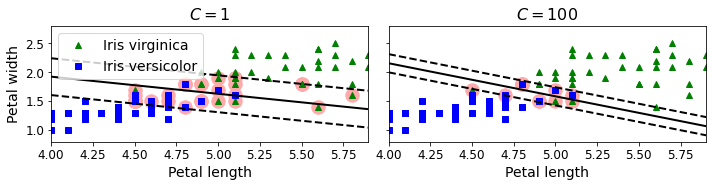

In [16]:
scaler = StandardScaler()
svm_clf1 = LinearSVC(C=1, loss="hinge", random_state=42)
svm_clf2 = LinearSVC(C=100, loss="hinge", random_state=42)

scaled_svm_clf1 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf1),
    ])
scaled_svm_clf2 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf2),
    ])

scaled_svm_clf1.fit(X, y)
scaled_svm_clf2.fit(X, y)

# 스케일되지 않은 파라미터로 변경
b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])
w1 = svm_clf1.coef_[0] / scaler.scale_
w2 = svm_clf2.coef_[0] / scaler.scale_
svm_clf1.intercept_ = np.array([b1])
svm_clf2.intercept_ = np.array([b2])
svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])

# 서포트 벡터 찾기 (libsvm과 달리 liblinear 라이브러리에서 제공하지 않기 때문에 
# LinearSVC에는 서포트 벡터가 저장되어 있지 않습니다.)
t = y * 2 - 1
support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()
svm_clf1.support_vectors_ = X[support_vectors_idx1]
svm_clf2.support_vectors_ = X[support_vectors_idx2]

fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

plt.sca(axes[0])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris versicolor")
plot_svc_decision_boundary(svm_clf1, 4, 5.9)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.title("$C = {}$".format(svm_clf1.C), fontsize=16)
plt.axis([4, 5.9, 0.8, 2.8])

plt.sca(axes[1])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 5.99)
plt.xlabel("Petal length", fontsize=14)
plt.title("$C = {}$".format(svm_clf2.C), fontsize=16)
plt.axis([4, 5.9, 0.8, 2.8])

save_fig("regularization_plot")

## 붓꽃 데이터셋을 적재하고 특성 스케일을 변경하고 Iris-Virginia 품종을 감지하기 위해 선형 SVM 모델을 훈련

### 데이터 만들기

In [11]:
# load_dataset 함수를 사용하여 데이터프레임으로 변환
df = sns.load_dataset('titanic')
#  IPython 디스플레이 설정 - 출력할 열의 개수 한도 늘리기
pd.set_option('display.max_columns', 15)

# NaN값이 많은 deck 열을 삭제, embarked와 내용이 겹치는 embark_town 열을 삭제
rdf = df.drop(['deck', 'embark_town'], axis=1)  

# age 열에 나이 데이터가 없는 모든 행을 삭제 - age 열(891개 중 177개의 NaN 값)
rdf = rdf.dropna(subset=['age'], how='any', axis=0)  

# embarked 열의 NaN값을 승선도시 중에서 가장 많이 출현한 값으로 치환하기
most_freq = rdf['embarked'].value_counts(dropna=True).idxmax()   
rdf['embarked'].fillna(most_freq, inplace=True)

# 분석에 활용할 열(속성)을 선택 
ndf = rdf[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'embarked']]

# 원핫인코딩 - 범주형 데이터를 모형이 인식할 수 있도록 숫자형으로 변환
onehot_sex = pd.get_dummies(ndf['sex'])
ndf = pd.concat([ndf, onehot_sex], axis=1)

onehot_embarked = pd.get_dummies(ndf['embarked'], prefix='town')
ndf = pd.concat([ndf, onehot_embarked], axis=1)

ndf.drop(['sex', 'embarked'], axis=1, inplace=True)

# 속성(변수) 선택
X=ndf[['pclass', 'age', 'sibsp', 'parch', 'female', 'male', 
       'town_C', 'town_Q', 'town_S']]  #독립 변수 X
y=ndf['survived']                      #종속 변수 Y

# 설명 변수 데이터를 정규화(normalization)
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)

# train data 와 test data로 구분(7:3 비율)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10) 

print('train data 개수: ', X_train.shape)
print('test data 개수: ', X_test.shape)
print('\n')

train data 개수:  (499, 9)
test data 개수:  (215, 9)




### SVM - 선형 커널을 이용하는 분류기 생성

In [12]:
# sklearn 라이브러리에서 SVM 분류 모형 가져오기
from sklearn import svm

# 모형 객체 생성 (kernel='rbf' 적용)
svm_model = svm.SVC(kernel='linear')

# train data를 가지고 모형 학습
svm_model.fit(X_train, y_train)   

# test data를 가지고 y_hat을 예측 (분류) 
y_hat = svm_model.predict(X_test)

print(y_hat[0:10])
print(y_test.values[0:10])
print('\n')

# 모형 성능 평가 - Confusion Matrix 계산
from sklearn import metrics 
svm_matrix = metrics.confusion_matrix(y_test, y_hat)  
print(svm_matrix)
print('\n')

# 모형 성능 평가 - 평가지표 계산
svm_report = metrics.classification_report(y_test, y_hat)            
print(svm_report)

[0 0 1 0 1 0 1 0 1 0]
[0 0 1 0 0 1 1 1 0 0]


[[106  19]
 [ 28  62]]


              precision    recall  f1-score   support

           0       0.79      0.85      0.82       125
           1       0.77      0.69      0.73        90

    accuracy                           0.78       215
   macro avg       0.78      0.77      0.77       215
weighted avg       0.78      0.78      0.78       215



## 비선형 커널을 이용한 SVM 

### 다항식을 이용한 선형 커널의 문제점 해결하기

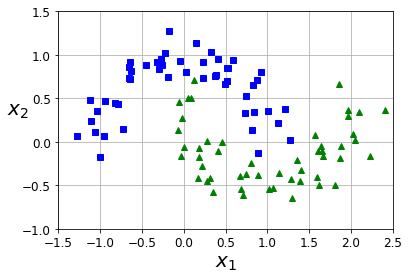

In [17]:
#데이터 생성 및 시각화
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

/Users/adam/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


그림 저장: moons_polynomial_svc_plot


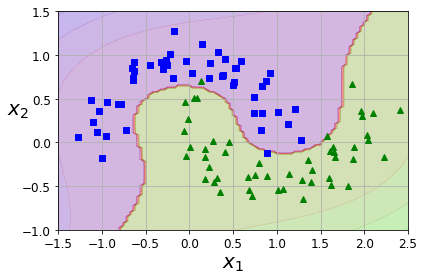

In [18]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

polynomial_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=10, loss="hinge", random_state=42))
    ])

polynomial_svm_clf.fit(X, y)

def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

save_fig("moons_polynomial_svc_plot")
plt.show()

### 3차 다항식 커널을 적용 

In [19]:
from sklearn.svm import SVC

poly_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
    ])
poly_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=1, kernel='poly'))])

### 10차 다항식 커널을 적용

In [20]:
poly100_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=10, coef0=100, C=5))
    ])
poly100_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=100, degree=10, kernel='poly'))])

### 다항식 커널의 결과 비교 시각화

그림 저장: moons_kernelized_polynomial_svc_plot


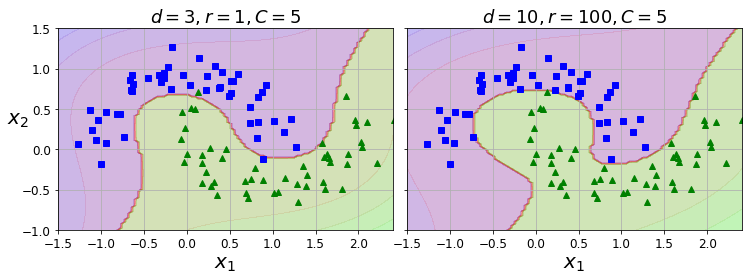

In [21]:
fig, axes = plt.subplots(ncols=2, figsize=(10.5, 4), sharey=True)

plt.sca(axes[0])
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=3, r=1, C=5$", fontsize=18)

plt.sca(axes[1])
plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=10, r=100, C=5$", fontsize=18)
plt.ylabel("")

save_fig("moons_kernelized_polynomial_svc_plot")
plt.show()

### 가우시안 RBF

그림 저장: kernel_method_plot


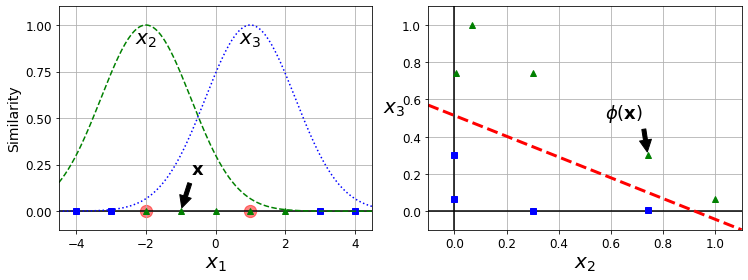

In [24]:
X1D = np.linspace(-4, 4, 9).reshape(-1, 1)

def gaussian_rbf(x, landmark, gamma):
    return np.exp(-gamma * np.linalg.norm(x - landmark, axis=1)**2)

gamma = 0.3

x1s = np.linspace(-4.5, 4.5, 200).reshape(-1, 1)
x2s = gaussian_rbf(x1s, -2, gamma)
x3s = gaussian_rbf(x1s, 1, gamma)

XK = np.c_[gaussian_rbf(X1D, -2, gamma), gaussian_rbf(X1D, 1, gamma)]
yk = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(10.5, 4))

plt.subplot(121)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.scatter(x=[-2, 1], y=[0, 0], s=150, alpha=0.5, c="red")
plt.plot(X1D[:, 0][yk==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][yk==1], np.zeros(5), "g^")
plt.plot(x1s, x2s, "g--")
plt.plot(x1s, x3s, "b:")
plt.gca().get_yaxis().set_ticks([0, 0.25, 0.5, 0.75, 1])
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"Similarity", fontsize=14)
plt.annotate(r'$\mathbf{x}$',
             xy=(X1D[3, 0], 0),
             xytext=(-0.5, 0.20),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.text(-2, 0.9, "$x_2$", ha="center", fontsize=20)
plt.text(1, 0.9, "$x_3$", ha="center", fontsize=20)
plt.axis([-4.5, 4.5, -0.1, 1.1])

plt.subplot(122)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(XK[:, 0][yk==0], XK[:, 1][yk==0], "bs")
plt.plot(XK[:, 0][yk==1], XK[:, 1][yk==1], "g^")
plt.xlabel(r"$x_2$", fontsize=20)
plt.ylabel(r"$x_3$  ", fontsize=20, rotation=0)
plt.annotate(r'$\phi\left(\mathbf{x}\right)$',
             xy=(XK[3, 0], XK[3, 1]),
             xytext=(0.65, 0.50),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.plot([-0.1, 1.1], [0.57, -0.1], "r--", linewidth=3)
plt.axis([-0.1, 1.1, -0.1, 1.1])
    
plt.subplots_adjust(right=1)

save_fig("kernel_method_plot")
plt.show()

### 가우시안 RBF 커널을 사용한 SVC 모델 생성

In [25]:
rbf_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001))
    ])
rbf_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=0.001, gamma=5))])

### gamma 와 C를 훈련시킨 모델

그림 저장: moons_rbf_svc_plot


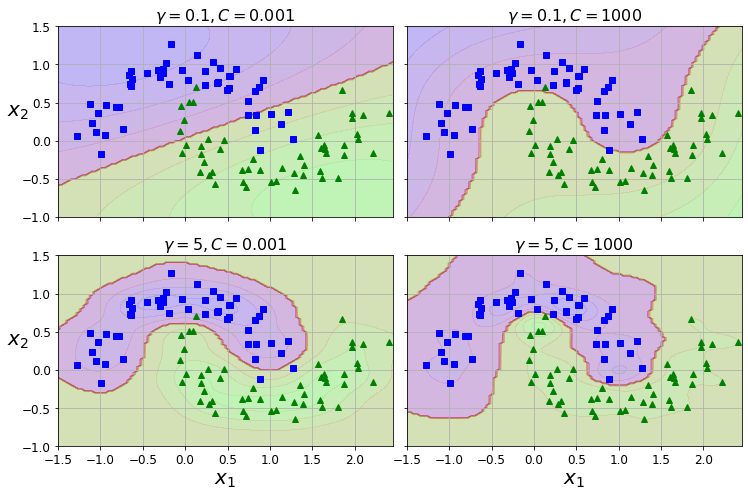

In [26]:
from sklearn.svm import SVC

gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
        ])
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10.5, 7), sharex=True, sharey=True)

for i, svm_clf in enumerate(svm_clfs):
    plt.sca(axes[i // 2, i % 2])
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.45, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")

save_fig("moons_rbf_svc_plot")
plt.show()

### XOR 형태의 데이터 만들기

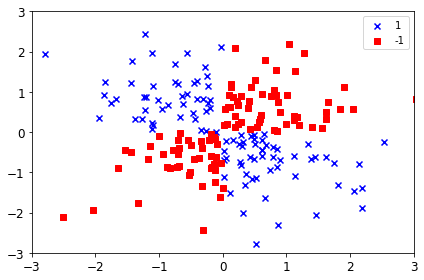

In [27]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(1)
X_xor = np.random.randn(200, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0,
                       X_xor[:, 1] > 0)
y_xor = np.where(y_xor, 1, -1)

plt.scatter(X_xor[y_xor == 1, 0],
            X_xor[y_xor == 1, 1],
            c='b', marker='x',
            label='1')
plt.scatter(X_xor[y_xor == -1, 0],
            X_xor[y_xor == -1, 1],
            c='r',
            marker='s',
            label='-1')

plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend(loc='best')
plt.tight_layout()
plt.show()

###  분류 결과를 그려주는 함수 생성

In [28]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # 마커와 컬러맵을 설정합니다.
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # 결정 경계를 그립니다.
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # 테스트 샘플을 부각하여 그립니다.
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')

### 선형 분류 결과

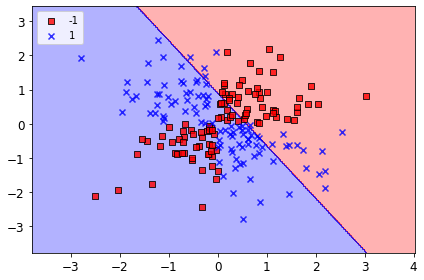

In [29]:
from sklearn.svm import SVC
svm_model = SVC(kernel='linear')
svm_model.fit(X_xor, y_xor)
plot_decision_regions(X_xor, y_xor,
                      classifier=svm_model)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

### sigmoid 적용

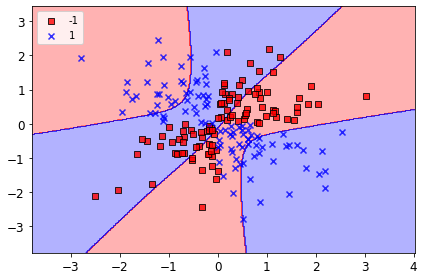

In [30]:
# from sklearn.svm import SVC
svm_model = SVC(kernel="sigmoid")
svm_model.fit(X_xor, y_xor)
plot_decision_regions(X_xor, y_xor,
                      classifier=svm_model)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

### 2차원 다항 커널 적용

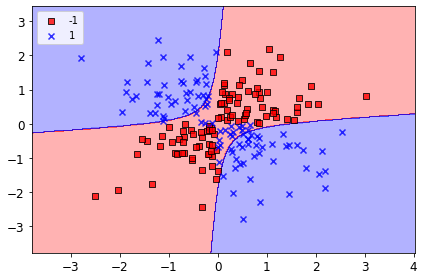

In [31]:
from sklearn.svm import SVC
svm_model = SVC(kernel='poly', degree=2, random_state=1, gamma=0.10, C=10.0)
svm_model.fit(X_xor, y_xor)
plot_decision_regions(X_xor, y_xor,
                      classifier=svm_model)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

### rbf 커널 적용

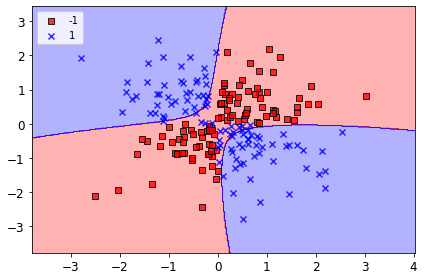

In [32]:
from sklearn.svm import SVC
svm_model = SVC(kernel='rbf', random_state=1, gamma=0.10, C=10.0)
svm_model.fit(X_xor, y_xor)
plot_decision_regions(X_xor, y_xor,
                      classifier=svm_model)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

## 타이타닉 데이터에 다양한 커널 적용

### sigmoid 커널 적용

In [33]:
# sklearn 라이브러리에서 SVM 분류 모형 가져오기
from sklearn.svm import SVC

# 모형 객체 생성 (kernel='rbf' 적용)
svm_model = SVC(kernel='sigmoid')

# train data를 가지고 모형 학습
svm_model.fit(X_train, y_train)   

# test data를 가지고 y_hat을 예측 (분류) 
y_hat = svm_model.predict(X_test)

print(y_hat[0:10])
print(y_test.values[0:10])
print('\n')

# 모형 성능 평가 - Confusion Matrix 계산
from sklearn import metrics 
svm_matrix = metrics.confusion_matrix(y_test, y_hat)  
print(svm_matrix)
print('\n')

# 모형 성능 평가 - 평가지표 계산
svm_report = metrics.classification_report(y_test, y_hat)            
print(svm_report)

[0 0 1 0 1 0 1 1 1 0]
[0 0 1 0 0 1 1 1 0 0]


[[91 34]
 [24 66]]


              precision    recall  f1-score   support

           0       0.79      0.73      0.76       125
           1       0.66      0.73      0.69        90

    accuracy                           0.73       215
   macro avg       0.73      0.73      0.73       215
weighted avg       0.74      0.73      0.73       215



### 2차원 다항 커널 적용

In [34]:
# sklearn 라이브러리에서 SVM 분류 모형 가져오기
from sklearn.svm import SVC

# 모형 객체 생성 (kernel='rbf' 적용)
svm_model = SVC(kernel='poly', degree=2, random_state=1, gamma=0.10, C=10.0)

# train data를 가지고 모형 학습
svm_model.fit(X_train, y_train)   

# test data를 가지고 y_hat을 예측 (분류) 
y_hat = svm_model.predict(X_test)

print(y_hat[0:10])
print(y_test.values[0:10])
print('\n')

# 모형 성능 평가 - Confusion Matrix 계산
from sklearn import metrics 
svm_matrix = metrics.confusion_matrix(y_test, y_hat)  
print(svm_matrix)
print('\n')

# 모형 성능 평가 - 평가지표 계산
svm_report = metrics.classification_report(y_test, y_hat)            
print(svm_report)

[0 0 1 0 1 1 1 0 1 0]
[0 0 1 0 0 1 1 1 0 0]


[[112  13]
 [ 29  61]]


              precision    recall  f1-score   support

           0       0.79      0.90      0.84       125
           1       0.82      0.68      0.74        90

    accuracy                           0.80       215
   macro avg       0.81      0.79      0.79       215
weighted avg       0.81      0.80      0.80       215



### 무한대 다차원 커널 적용(rbf)

In [35]:
# sklearn 라이브러리에서 SVM 분류 모형 가져오기
from sklearn.svm import SVC

# 모형 객체 생성 (kernel='rbf' 적용)
svm_model = SVC(kernel='rbf', random_state=1, gamma=0.10, C=10.0)

# train data를 가지고 모형 학습
svm_model.fit(X_train, y_train)   

# test data를 가지고 y_hat을 예측 (분류) 
y_hat = svm_model.predict(X_test)

print(y_hat[0:10])
print(y_test.values[0:10])
print('\n')

# 모형 성능 평가 - Confusion Matrix 계산
from sklearn import metrics 
svm_matrix = metrics.confusion_matrix(y_test, y_hat)  
print(svm_matrix)
print('\n')

# 모형 성능 평가 - 평가지표 계산
svm_report = metrics.classification_report(y_test, y_hat)            
print(svm_report)

[0 0 1 0 0 1 1 0 0 0]
[0 0 1 0 0 1 1 1 0 0]


[[119   6]
 [ 32  58]]


              precision    recall  f1-score   support

           0       0.79      0.95      0.86       125
           1       0.91      0.64      0.75        90

    accuracy                           0.82       215
   macro avg       0.85      0.80      0.81       215
weighted avg       0.84      0.82      0.82       215



## 연습문제

### 먼저 데이터셋을 로드하고 훈련 세트와 테스트 세트로 나눔 train_test_split() 함수를 사용할 수 있지만 보통 처음 60,000개의 샘플을 훈련 세트로 사용하고 나머지는 10,000개를 테스트 세트로 사용합니다(이렇게 하면 다른 사람들의 모델과 성능을 비교하기 좋습니다):

In [36]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)

X = mnist["data"]
y = mnist["target"].astype(np.uint8)

X_train = X[:60000]
y_train = y[:60000]
X_test = X[60000:]
y_test = y[60000:]

### 선형 SVM 분류기부터 시작. 이 모델은 자동으로 OvA(또는 OvR) 전략을 사용하므로 특별히 처리해 줄 것이 없습니다.

In [37]:
lin_clf = LinearSVC(random_state=42)
lin_clf.fit(X_train, y_train)

/Users/adam/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC(random_state=42)

### 훈련 세트에 대한 예측을 만들어 정확도를 측정

In [38]:
from sklearn.metrics import accuracy_score

y_pred = lin_clf.predict(X_train)
accuracy_score(y_train, y_pred)

0.8348666666666666

### MNIST에서 83.5% 정확도면 나쁜 성능 선형 모델이 MNIST 문제에 너무 단순하기 때문이지만 먼저 데이터의 스케일을 조정할 필요가 있음

In [39]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32))
X_test_scaled = scaler.transform(X_test.astype(np.float32))

lin_clf = LinearSVC(random_state=42)
lin_clf.fit(X_train_scaled, y_train)

/Users/adam/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC(random_state=42)

In [40]:
y_pred = lin_clf.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

0.9217333333333333

### 훨씬 나아졌지만 여전히 MNIST에서 좋은 성능은 아닙니다. SVM을 사용한다면 커널 함수를 사용 RBF 커널(기본값)로 SVC를 적용

In [41]:
svm_clf = SVC(gamma="scale")
svm_clf.fit(X_train_scaled[:10000], y_train[:10000])

SVC()

In [42]:
y_pred = svm_clf.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

0.9455333333333333

### 6배나 적은 데이터에서 모델을 훈련시켰지만 더 좋은 성능을 얻음 
### 교차 검증을 사용한 랜덤 서치로 하이퍼파라미터 튜닝 수행
### 진행을 빠르게 하기 위해 작은 데이터셋으로 작업하

In [43]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(svm_clf, param_distributions, n_iter=10, verbose=2, cv=3)
rnd_search_cv.fit(X_train_scaled[:1000], y_train[:1000])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] C=6.707158515462564, gamma=0.09851601822698676 ..................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ... C=6.707158515462564, gamma=0.09851601822698676, total=   1.0s
[CV] C=6.707158515462564, gamma=0.09851601822698676 ..................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] ... C=6.707158515462564, gamma=0.09851601822698676, total=   1.0s
[CV] C=6.707158515462564, gamma=0.09851601822698676 ..................
[CV] ... C=6.707158515462564, gamma=0.09851601822698676, total=   0.9s
[CV] C=9.16835108791622, gamma=0.015443482761795801 ..................
[CV] ... C=9.16835108791622, gamma=0.015443482761795801, total=   1.0s
[CV] C=9.16835108791622, gamma=0.015443482761795801 ..................
[CV] ... C=9.16835108791622, gamma=0.015443482761795801, total=   0.9s
[CV] C=9.16835108791622, gamma=0.015443482761795801 ..................
[CV] ... C=9.16835108791622, gamma=0.015443482761795801, total=   0.9s
[CV] C=10.759890683309049, gamma=0.06355140689094196 .................
[CV] .. C=10.759890683309049, gamma=0.06355140689094196, total=   0.9s
[CV] C=10.759890683309049, gamma=0.06355140689094196 .................
[CV] .. C=10.759890683309049, gamma=0.06355140689094196, total=   0.9s
[CV] C=10.759890683309049, gamma=0.06355140689094196 .................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   24.4s finished


RandomizedSearchCV(cv=3, estimator=SVC(),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff4319e7520>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff4312bcc10>},
                   verbose=2)

In [44]:
rnd_search_cv.best_estimator_

SVC(C=6.9560793360264555, gamma=0.0011610546192103027)

In [46]:
rnd_search_cv.best_score_

0.8599917282552013

### 점수는 낮지만 1,000개의 샘플만 사용한 것을 기억해야 합니다. 전체 데이터셋으로 최선의 모델을 재훈련

In [47]:
rnd_search_cv.best_estimator_.fit(X_train_scaled, y_train)

SVC(C=6.9560793360264555, gamma=0.0011610546192103027)

In [48]:
y_pred = rnd_search_cv.best_estimator_.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

0.9978333333333333

In [49]:
y_pred = rnd_search_cv.best_estimator_.predict(X_test_scaled)
accuracy_score(y_test, y_pred)

0.9731

### 아주 나쁘지 않지만 확실히 모델이 다소 과대적합되었습니다. 하이퍼파라미터를 조금 더 수정할 수 있지만(가령, C와/나 gamma를 감소시킵니다) 그렇게 하면 테스트 세트에 과대적합될 위험이 있습니다. 하이퍼파라미터 C=5와 gamma=0.005에서 더 나은 성능(98% 이상의 정확도)을 얻을 수 있으며 훈련 세트를 더 많이 사용해서 더 오래 랜덤 서치를 수행하면 이런 값을 얻을 수 있을지 모름

# 의사 결정 나무(Decision Tree)

## 공통 코드

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 결정 트리 학습과 시각화

In [2]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # 꽃잎 길이와 너비
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2, random_state=42)

In [3]:
from graphviz import Source
from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf,
        out_file=os.path.join(IMAGES_PATH, "iris_tree.dot"),
        feature_names=iris.feature_names[2:],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

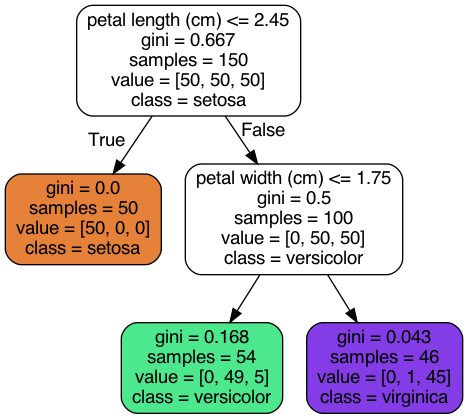

In [4]:
import pygraphviz as pga
from IPython.display import Image
graph = pga.AGraph('/Users/adam/images/decision_trees/iris_tree.dot')
graph.draw("iris_tree.png", prog='dot')
Image("iris_tree.png")

그림 저장: decision_tree_decision_boundaries_plot


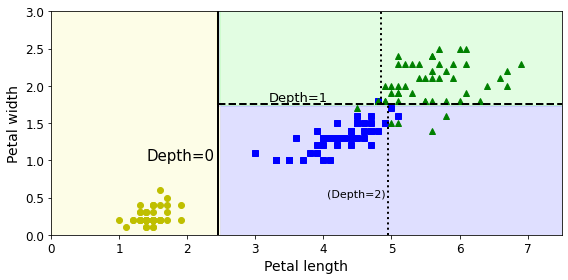

In [5]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)

save_fig("decision_tree_decision_boundaries_plot")
plt.show()

In [6]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [7]:
tree_clf.predict([[5, 1.5]])

array([1])

### min_samples_leaf 매개변수

그림 저장: min_samples_leaf_plot


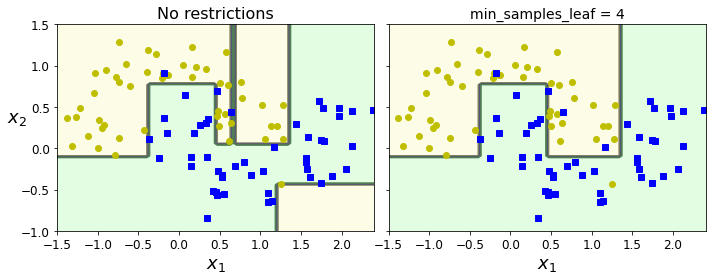

In [8]:
from sklearn.datasets import make_moons
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("No restrictions", fontsize=16)
plt.sca(axes[1])
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)
plt.ylabel("")

save_fig("min_samples_leaf_plot")
plt.show()

## 타이타닉 생존자 분류
### 데이터 가져오기

In [9]:
### 기본 라이브러리 불러오기
import pandas as pd
import seaborn as sns

# load_dataset 함수를 사용하여 데이터프레임으로 변환
#df = sns.load_dataset('titanic')
df = pd.read_csv('./data/titanic.csv')
#  IPython 디스플레이 설정 - 출력할 열의 개수 한도 늘리기
pd.set_option('display.max_columns', 15)

# NaN값이 많은 deck 열을 삭제, embarked와 내용이 겹치는 embark_town 열을 삭제
rdf = df.drop(['deck', 'embark_town'], axis=1)  

# age 열에 나이 데이터가 없는 모든 행을 삭제 - age 열(891개 중 177개의 NaN 값)
rdf = rdf.dropna(subset=['age'], how='any', axis=0)  

# embarked 열의 NaN값을 승선도시 중에서 가장 많이 출현한 값으로 치환하기
most_freq = rdf['embarked'].value_counts(dropna=True).idxmax()   
rdf['embarked'].fillna(most_freq, inplace=True)

# 분석에 활용할 열(속성)을 선택 
ndf = rdf[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'embarked']]

# 원핫인코딩 - 범주형 데이터를 모형이 인식할 수 있도록 숫자형으로 변환
onehot_sex = pd.get_dummies(ndf['sex'])
ndf = pd.concat([ndf, onehot_sex], axis=1)

onehot_embarked = pd.get_dummies(ndf['embarked'], prefix='town')
ndf = pd.concat([ndf, onehot_embarked], axis=1)

ndf.drop(['sex', 'embarked'], axis=1, inplace=True)

# 속성(변수) 선택
X=ndf[['pclass', 'age', 'sibsp', 'parch', 'female', 'male', 
       'town_C', 'town_Q', 'town_S']]  #독립 변수 X
y=ndf['survived']                      #종속 변수 Y

# 설명 변수 데이터를 정규화(normalization)
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)

# train data 와 test data로 구분(7:3 비율)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10) 

### 타이타닉 데이터에 의사결정 나무 적용

In [10]:
# sklearn 라이브러리에서 Decision Tree 분류 모형 가져오기
from sklearn import tree

# 모형 객체 생성 (criterion='entropy' 적용 - 기본은 gini)
#최대 가지는 5단계로 설정
#단계가 높아지면 모형 학습에 사용하는 훈련 데이터에 대한 예측은 정확해지만 과적합 문제가 발생할 수 있음
tree_model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5)
# train data를 가지고 모형 학습
tree_model.fit(X_train, y_train)   

# test data를 가지고 y_hat을 예측 (분류) 
y_hat = tree_model.predict(X_test) 

print(y_hat[0:10])
print(y_test.values[0:10])
print('\n')

# 모형 성능 평가 - Confusion Matrix 계산
from sklearn import metrics 
tree_matrix = metrics.confusion_matrix(y_test, y_hat)  
print(tree_matrix)
print('\n')

# 모형 성능 평가 - 평가지표 계산
tree_report = metrics.classification_report(y_test, y_hat)            
print(tree_report)

[0 0 1 0 0 1 1 0 0 0]
[0 0 1 0 0 1 1 1 0 0]


[[121   4]
 [ 35  55]]


              precision    recall  f1-score   support

           0       0.78      0.97      0.86       125
           1       0.93      0.61      0.74        90

    accuracy                           0.82       215
   macro avg       0.85      0.79      0.80       215
weighted avg       0.84      0.82      0.81       215



### 특성 중요도 파악

(-1.0, 9.0)

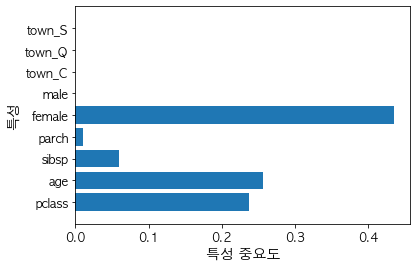

In [11]:
#특성 중요도 파악
import numpy as np
import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager, rc

#매킨토시의 경우
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
#윈도우의 경우
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)

n_features = X.data.shape[1]

plt.barh(np.arange(n_features), tree_model.feature_importances_, align='center')
plt.yticks(np.arange(n_features), ['pclass', 'age', 'sibsp', 'parch', 'female', 'male', 
       'town_C', 'town_Q', 'town_S'])
plt.xlabel("특성 중요도")
plt.ylabel("특성")
plt.ylim(-1, n_features)

그림 저장: sensitivity_to_rotation_plot


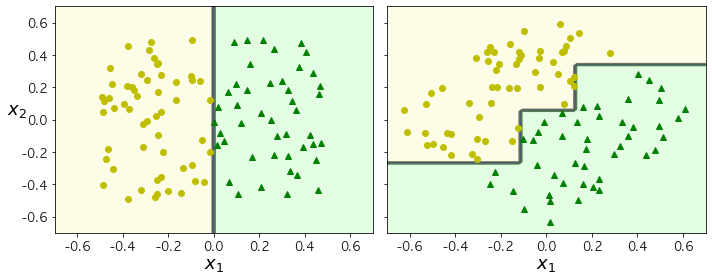

In [12]:
mpl.rcParams['axes.unicode_minus'] = False

np.random.seed(6)
Xs = np.random.rand(100, 2) - 0.5
ys = (Xs[:, 0] > 0).astype(np.float32) * 2

angle = np.pi / 4
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)

tree_clf_s = DecisionTreeClassifier(random_state=42)
tree_clf_s.fit(Xs, ys)
tree_clf_sr = DecisionTreeClassifier(random_state=42)
tree_clf_sr.fit(Xsr, ys)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf_s, Xs, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.sca(axes[1])
plot_decision_boundary(tree_clf_sr, Xsr, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.ylabel("")

save_fig("sensitivity_to_rotation_plot")
plt.show()

## 사용자 행동 패턴 인식 분류

### 데이터 가져오기

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# features.txt 파일에는 피처 이름 index와 피처명이 공백으로 분리되어 있음. 이를 DataFrame으로 로드.
feature_name_df = pd.read_csv('./data/UCIHARDataset/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])

# 피처명 index를 제거하고, 피처명만 리스트 객체로 생성한 뒤 샘플로 10개만 추출
feature_name = feature_name_df.iloc[:, 1].values.tolist()
print('전체 피처명에서 10개만 추출:', feature_name[:10])

전체 피처명에서 10개만 추출: ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


### 중복된 피쳐이름을 변경해서 데이터를 로드

In [24]:
#중복된 피쳐이름 확인
feature_dup_df = feature_name_df.groupby('column_name').count()
print(feature_dup_df[feature_dup_df['column_index'] > 1].count())
feature_dup_df[feature_dup_df['column_index'] > 1].head()

column_index    42
dtype: int64


,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3


In [28]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                         if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

import pandas as pd

def get_human_dataset( ):
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('./data/UCIHARDataset/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
    
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('./data/UCIHARDataset/train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('./data/UCIHARDataset/test/X_test.txt',sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('./data/UCIHARDataset/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('./data/UCIHARDataset/test/y_test.txt',sep='\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = get_human_dataset()

In [31]:
#데이터 정보 확인
print('## 학습 피처 데이터셋 info()')
X_train.info()

## 학습 피처 데이터셋 info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB


In [30]:
#행동의 분류 개수 확인
print(y_train['action'].value_counts())

6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: action, dtype: int64


### 분류 모델 생성

In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# 반복 시 마다 동일한 예측 결과 도출을 위해 random_state 설정
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train , y_train)
pred = dt_clf.predict(X_test)
accuracy = accuracy_score(y_test , pred)
print('결정 트리 예측 정확도: {0:.4f}'.format(accuracy))

# DecisionTreeClassifier의 하이퍼 파라미터 추출
print('DecisionTreeClassifier 기본 하이퍼 파라미터:\n', dt_clf.get_params())

결정 트리 예측 정확도: 0.8548
DecisionTreeClassifier 기본 하이퍼 파라미터:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': 156, 'splitter': 'best'}


In [33]:
#max_depth 하이퍼 파라미터 조정
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth' : [ 6, 8 ,10, 12, 16 ,20, 24]
}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1 )
grid_cv.fit(X_train , y_train)
print('GridSearchCV 최고 평균 정확도 수치:{0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:', grid_cv.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  1.2min finished


GridSearchCV 최고 평균 정확도 수치:0.8513
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 16}


In [34]:
# GridSearchCV객체의 cv_results_ 속성을 DataFrame으로 생성. 
cv_results_df = pd.DataFrame(grid_cv.cv_results_)

# max_depth 파라미터 값과 그때의 테스트(Evaluation)셋, 학습 데이터 셋의 정확도 수치 추출
cv_results_df[['param_max_depth', 'mean_test_score']]

,param_max_depth,mean_test_score
0,6,0.850791
1,8,0.851069
2,10,0.851209
3,12,0.844135
4,16,0.851344
5,20,0.850800
6,24,0.849440


In [35]:
max_depths = [ 6, 8 ,10, 12, 16 ,20, 24]
# max_depth 값을 변화 시키면서 그때마다 학습과 테스트 셋에서의 예측 성능 측정
for depth in max_depths:
    dt_clf = DecisionTreeClassifier(max_depth=depth, random_state=156)
    dt_clf.fit(X_train , y_train)
    pred = dt_clf.predict(X_test)
    accuracy = accuracy_score(y_test , pred)
    print('max_depth = {0} 정확도: {1:.4f}'.format(depth , accuracy))

max_depth = 6 정확도: 0.8558
max_depth = 8 정확도: 0.8707
max_depth = 10 정확도: 0.8673
max_depth = 12 정확도: 0.8646
max_depth = 16 정확도: 0.8575
max_depth = 20 정확도: 0.8548
max_depth = 24 정확도: 0.8548


In [36]:
#max_depth 와 min_sample_split 조정
params = {
    'max_depth' : [ 8 , 12, 16 ,20], 
    'min_samples_split' : [16,24],
}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1 )
grid_cv.fit(X_train , y_train)
print('GridSearchCV 최고 평균 정확도 수치: {0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:', grid_cv.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  1.6min finished


GridSearchCV 최고 평균 정확도 수치: 0.8549
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 8, 'min_samples_split': 16}


In [37]:
best_df_clf = grid_cv.best_estimator_
pred1 = best_df_clf.predict(X_test)
accuracy = accuracy_score(y_test , pred1)
print('결정 트리 예측 정확도:{0:.4f}'.format(accuracy))

결정 트리 예측 정확도:0.8717


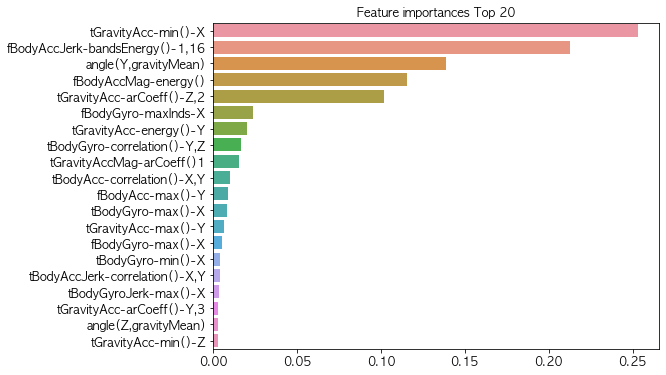

In [38]:
#중요도 파악
import seaborn as sns

ftr_importances_values = best_df_clf.feature_importances_
# Top 중요도로 정렬을 쉽게 하고, 시본(Seaborn)의 막대그래프로 쉽게 표현하기 위해 Series변환
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns  )
# 중요도값 순으로 Series를 정렬
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()

## 연습문제

### make_moons(n_samples=1000, noise=0.4)를 사용해 데이터셋을 생성

In [13]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=10000, noise=0.4, random_state=42)

### train_test_split()을 사용해 훈련 세트와 테스트 세트로 나눔

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### DecisionTreeClassifier의 최적의 매개변수를 찾기 위해 교차 검증과 함께 그리드 탐색을 수행(GridSearchCV를 사용) 

In [15]:
from sklearn.model_selection import GridSearchCV

params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=3)

grid_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 294 candidates, totalling 882 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 882 out of 882 | elapsed:    6.7s finished


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4]},
             verbose=1)

### 찾은 매개변수를 사용해 전체 훈련 세트에 대해 모델을 훈련시키고 테스트 세트에서 성능을 측정

In [16]:
grid_search_cv.best_estimator_

DecisionTreeClassifier(max_leaf_nodes=17, random_state=42)

In [17]:
from sklearn.metrics import accuracy_score

y_pred = grid_search_cv.predict(X_test)
accuracy_score(y_test, y_pred)

0.8695

### 훈련 세트의 서브셋을 1.000개 생성해서 각각은 무작위로 선택된 1007 개의 샘플을 담도록 작성 

In [18]:
from sklearn.model_selection import ShuffleSplit

n_trees = 1000
n_instances = 100

mini_sets = []

rs = ShuffleSplit(n_splits=n_trees, test_size=len(X_train) - n_instances, random_state=42)
for mini_train_index, mini_test_index in rs.split(X_train):
    X_mini_train = X_train[mini_train_index]
    y_mini_train = y_train[mini_train_index]
    mini_sets.append((X_mini_train, y_mini_train))

### 이전에 찾은 최적의 매개변수를 사용해 각 서브셋에 결정 트리를 훈련시키고 테스트 세트로 이 1.000개의 결정 트리를 평가

In [19]:
from sklearn.base import clone

forest = [clone(grid_search_cv.best_estimator_) for _ in range(n_trees)]

accuracy_scores = []

for tree, (X_mini_train, y_mini_train) in zip(forest, mini_sets):
    tree.fit(X_mini_train, y_mini_train)
    
    y_pred = tree.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

np.mean(accuracy_scores)

0.8054499999999999

### 테스트 세트 샘플에 대해 1,000개의 결정 트리 예측을 만들고 다수로 나온 예측만 취하기

In [20]:
Y_pred = np.empty([n_trees, len(X_test)], dtype=np.uint8)

for tree_index, tree in enumerate(forest):
    Y_pred[tree_index] = tree.predict(X_test)

from scipy.stats import mode

y_pred_majority_votes, n_votes = mode(Y_pred, axis=0)

### 테스트 세트에서 이 예측을 평가 

In [21]:
accuracy_score(y_test, y_pred_majority_votes.reshape([-1]))

0.872